### Boilerplate Code
The code below is for interacting with the structure at UMN. You can ignore it.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ROOT)

from ana import dark_brem_lhe as dbl
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

GeVtoPb = 3.894e8

def read_mg(h5f) :
    return (
        pd.read_hdf(h5f,'events'),
        pd.read_hdf(h5f,'total_xsec').groupby('energy').mean().iloc[0]['xsec']
    )

def read_ww(d) :
    return (
        pd.read_csv(os.path.join(d,'dsdx.csv')), 
        pd.read_csv(os.path.join(d,'xsec.csv')).iloc[0]['xsec']
    )

def comp_dsdx(mg_data, ww_data, *,
              title = None,
              filename = None,
              yscale = 'linear',
              do_ratio = True,
              scale_alpha = True
             ) :
    (raw, ratio) = plt.figure().subplots(ncols = 1, nrows = 2, 
                                     sharex = 'col', 
                                     gridspec_kw = dict(height_ratios = [3,1]))
    plt.subplots_adjust(hspace = 0)
    raw.set_ylabel(r'$d\sigma/dx$ [GeV$^2$]')
    raw.set_yscale(yscale)
    ratio.set_ylabel('G4DB/MG')
    ratio.set_xlabel('1-x')
    ratio.set_xscale('log')
        
    for name, ww_dir in ww_data :
        ww, ww_total_xsec = read_ww(ww_dir)
        raw.scatter(1-ww['x'],ww['dsdx'],
                    label=f'{name} ($\sigma = {ww_total_xsec:.2e}$ pb)')
    
    mg_vals = []
    mg_cents = []
    for name, mg_file in mg_data :
        mg, mg_total_xsec = read_mg(mg_file)
        mgv, mgb = np.histogram(1-mg['aprime_energy']/mg['incident_energy'], density=True,
                                bins=np.logspace(-5,0,100))
        # scale alpha if instructed to do so
        if scale_alpha :
            mg_total_xsec *= (127.9/137)**3
    
        # scale ds/dx in event fraction to xsec in GeV
        mgv *= mg_total_xsec / GeVtoPb
        mg_vals.append(mgv)
        mgc = (mgb[1:]+mgb[:-1])/2
        mg_cents.append(mgc)
        raw.hist(mgc,bins=mgb,weights=mgv,
                 histtype='step', lw=2,
                 label=f'{name} ($\sigma = {mg_total_xsec:.2e}$ pb)')
    
    raw.legend(loc='upper left',bbox_to_anchor=(1,1))
    raw.set_title(title)

    if do_ratio :
        if len(mg_data) == 1 :
            for name, ww_dir in ww_data :
                ww, _ = read_ww(ww_dir)
                ww_interp = interp1d(1-ww['x'],ww['dsdx'])
                sl = (mgv > 0)
                ratio.scatter(mgc[sl], [ww_interp(y) for y in mgc[sl]] / mgv[sl])
        elif len(ww_data) == 1 :
            ww, _ = read_ww(ww_data[0][1])
            ww_interp = interp1d(1-ww['x'],ww['dsdx'])
            for mg_cent, mg_val in zip(mg_cents, mg_vals) :
                sl = mg_val > 0
                ratio.scatter(mg_cent[sl], [ww_interp(y) for y in mg_cent[sl]] / mg_val[sl])
        elif len(mg_data) == len(ww_data) :
            for mg_cent, mg_val, (_, ww_dir) in zip(mg_cents,mg_vals,ww_data) :
                ww, _ = read_ww(ww_dir)
                ww_interp = interp1d(1-ww['x'],ww['dsdx'])
                sl = (mg > 0)
                ratio.scatter(mg_cent[sl], [ww_interp(y) for y in mg_cent[sl]] / mg_val[sl])
                
    if filename is not None :
        plt.savefig(filename+'.pdf',bbox_inches='tight')
    plt.show()

# Cross Section Discrepancy
After thorough debugging of the code performing the WW-approximation, it is time to look for a _physical_ reason for the discrepancy between MG and WW. The first step is to make sure we are doing an apples-to-apples comparison, so I have generated MG samples at a few A' masses both with and without the inelastic form factor. The plotting function `comp_dsdx` scales the MG cross section values from it's alpha (`1/127.9`) to our alpha (`1/137`).

All of the following plots are **1 TeV muons on a copper target**. A few observations
1. Higher A' mass shifts the dsigma/dx distribution towards higher `x`.
2. The discrepancy between WW and MG _shrinks_ as the A' mass increases.
3. The original closeness of WW and MG seems to be due to the inelastic form factor in MG accounting for the error in the approximation.

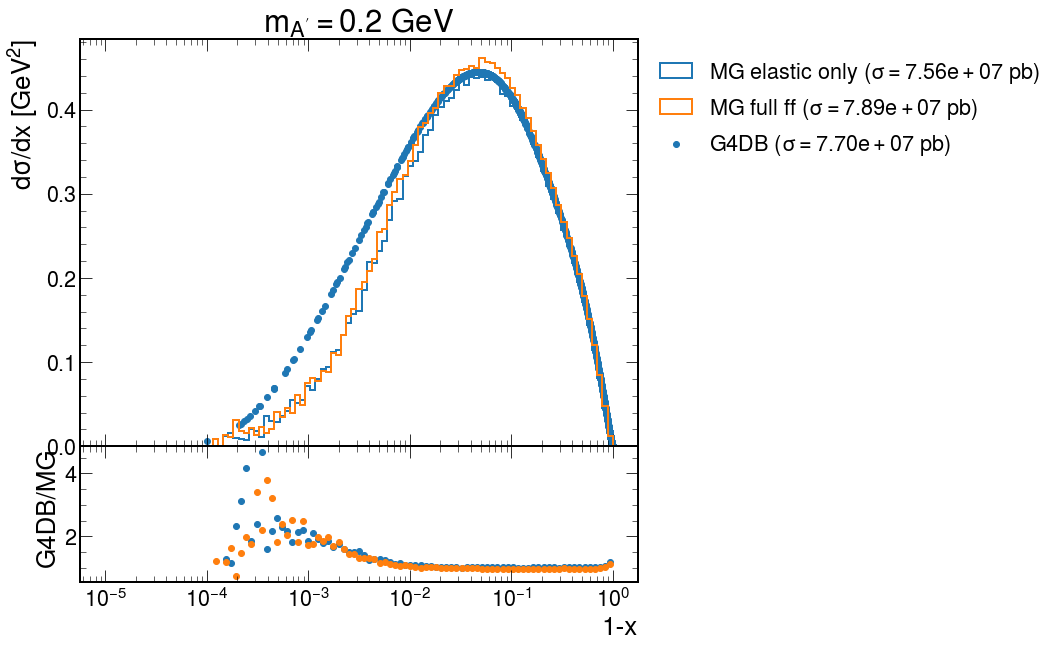

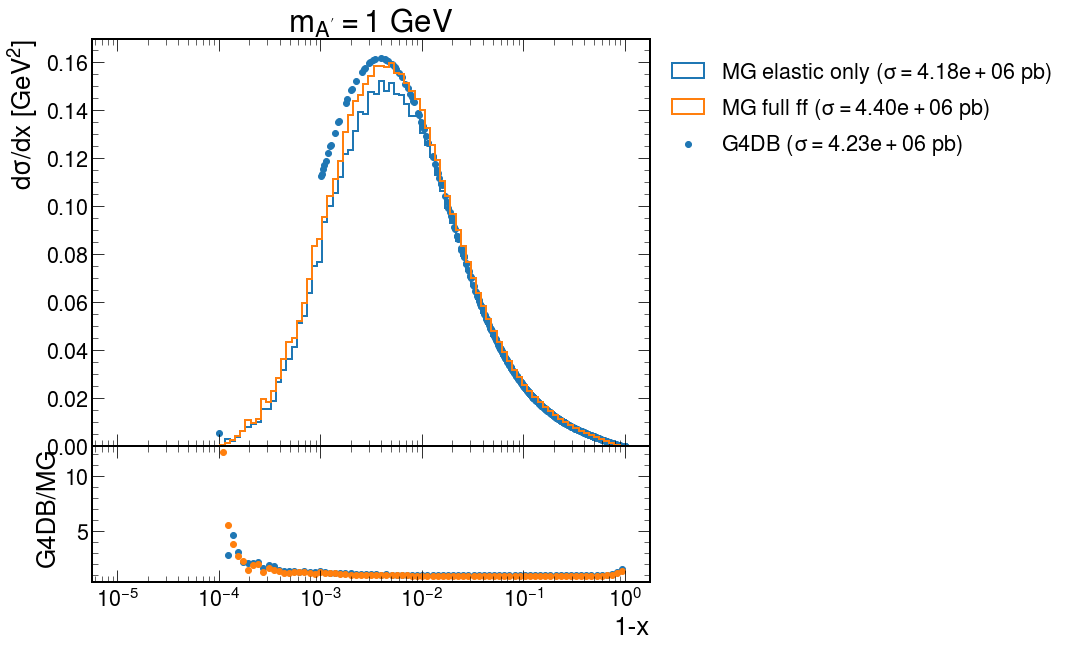

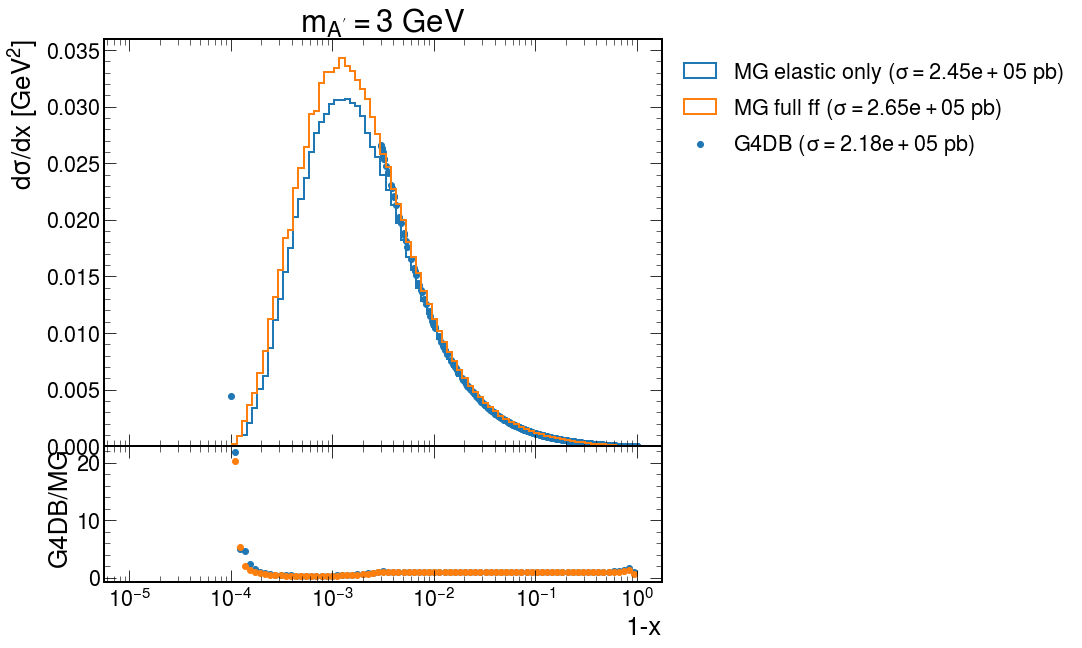

In [34]:
for ma in ['0.2','1','3'] :
    mg_samples = [ # MG samples, H5 files are tables extracted from LHE using ana/dark_brem_lhe.py
            ('MG elastic only',f'dblib/xsec/fffix_muon_copper_incident_1000GeV_mA_{ma}GeV_elastic_only.h5'),
            ('MG full ff',f'dblib/xsec/fffix_muon_copper_incident_1000GeV_mA_{ma}GeV_full_ff.h5'),
        ]
    comp_dsdx(
        mg_samples,
        [ # WW samples, directories with 'dsdx.csv' and 'xsec.csv' written by xsec-dbg executable
            ('G4DB',f'sim/sw/xsec/mu_{ma}GeV')
        ],
        title='$m_{A\'} = '+ma+'$ GeV'
    )